# The DREAM chopper cascade

In this notebook, we simulate the beamline of the DREAM instrument and its pulse-shaping choppers.
We then show how to use `essreduce`'s `time_of_flight` module to compute neutron wavelengths from their arrival times at the detectors.

The case of DREAM is interesting because the pulse-shaping choppers can be used in a number of different modes,
and the number of cutouts the choppers have typically does not equal the number of frames observed at the detectors.

In [1]:
import plopp as pp
import scipp as sc
import scippnexus as snx
from scippneutron.chopper import DiskChopper
from ess.reduce.nexus.types import AnyRun, RawDetector, SampleRun, NeXusDetectorName
from ess.reduce.time_of_flight import *

## Setting up the beamline

### Creating the beamline choppers

We begin by defining the chopper settings for our beamline.
In principle, the chopper setting could simply be read from a NeXus file.

The DREAM instrument has

- 2 pulse-shaping choppers (PSC)
- 1 overlap chopper (OC)
- 1 band-control chopper (BCC)
- 1 T0 chopper

In [2]:
psc1 = DiskChopper(
    frequency=sc.scalar(14.0, unit="Hz"),
    beam_position=sc.scalar(0.0, unit="deg"),
    phase=sc.scalar(286 - 180, unit="deg"),
    axle_position=sc.vector(value=[0, 0, -70.405], unit="m"),
    slit_begin=sc.array(
        dims=["cutout"],
        values=[-1.23, 70.49, 84.765, 113.565, 170.29, 271.635, 286.035, 301.17],
        unit="deg",
    ),
    slit_end=sc.array(
        dims=["cutout"],
        values=[1.23, 73.51, 88.035, 116.835, 175.31, 275.565, 289.965, 303.63],
        unit="deg",
    ),
    slit_height=sc.scalar(10.0, unit="cm"),
    radius=sc.scalar(30.0, unit="cm"),
)

psc2 = DiskChopper(
    frequency=sc.scalar(-14.0, unit="Hz"),
    beam_position=sc.scalar(0.0, unit="deg"),
    phase=sc.scalar(-236, unit="deg"),
    axle_position=sc.vector(value=[0, 0, -70.395], unit="m"),
    slit_begin=sc.array(
        dims=["cutout"],
        values=[-1.23, 27.0, 55.8, 142.385, 156.765, 214.115, 257.23, 315.49],
        unit="deg",
    ),
    slit_end=sc.array(
        dims=["cutout"],
        values=[1.23, 30.6, 59.4, 145.615, 160.035, 217.885, 261.17, 318.11],
        unit="deg",
    ),
    slit_height=sc.scalar(10.0, unit="cm"),
    radius=sc.scalar(30.0, unit="cm"),
)

oc = DiskChopper(
    frequency=sc.scalar(14.0, unit="Hz"),
    beam_position=sc.scalar(0.0, unit="deg"),
    phase=sc.scalar(297 - 180 - 90, unit="deg"),
    axle_position=sc.vector(value=[0, 0, -70.376], unit="m"),
    slit_begin=sc.array(dims=["cutout"], values=[-27.6 * 0.5], unit="deg"),
    slit_end=sc.array(dims=["cutout"], values=[27.6 * 0.5], unit="deg"),
    slit_height=sc.scalar(10.0, unit="cm"),
    radius=sc.scalar(30.0, unit="cm"),
)

bcc = DiskChopper(
    frequency=sc.scalar(112.0, unit="Hz"),
    beam_position=sc.scalar(0.0, unit="deg"),
    phase=sc.scalar(240 - 180, unit="deg"),
    axle_position=sc.vector(value=[0, 0, -66.77], unit="m"),
    slit_begin=sc.array(dims=["cutout"], values=[-36.875, 143.125], unit="deg"),
    slit_end=sc.array(dims=["cutout"], values=[36.875, 216.875], unit="deg"),
    slit_height=sc.scalar(10.0, unit="cm"),
    radius=sc.scalar(30.0, unit="cm"),
)

t0 = DiskChopper(
    frequency=sc.scalar(28.0, unit="Hz"),
    beam_position=sc.scalar(0.0, unit="deg"),
    phase=sc.scalar(280 - 180, unit="deg"),
    axle_position=sc.vector(value=[0, 0, -63.5], unit="m"),
    slit_begin=sc.array(dims=["cutout"], values=[-314.9 * 0.5], unit="deg"),
    slit_end=sc.array(dims=["cutout"], values=[314.9 * 0.5], unit="deg"),
    slit_height=sc.scalar(10.0, unit="cm"),
    radius=sc.scalar(30.0, unit="cm"),
)

disk_choppers = {"psc1": psc1, "psc2": psc2, "oc": oc, "bcc": bcc, "t0": t0}

It is possible to visualize the properties of the choppers by inspecting their `repr`:

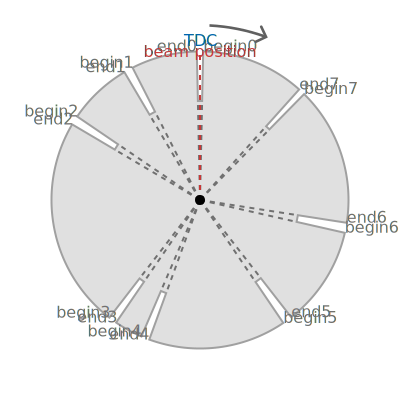

In [3]:
psc2

Define the source position which is required to compute the distance that neutrons travelled.

In [4]:
source_position = sc.vector([0, 0, -76.55], unit="m")

### Adding a detector

In [5]:
Ltotal = sc.scalar(76.55 + 1.125, unit="m")

## Creating some neutron events

We create a semi-realistic set of neutron events based on the ESS pulse.

In [6]:
from ess.reduce.time_of_flight.fakes import FakeBeamline

ess_beamline = FakeBeamline(
    choppers=disk_choppers,
    source_position=source_position,
    monitors={"detector": Ltotal},
    run_length=sc.scalar(1 / 14, unit="s") * 4,
    events_per_pulse=200_000,
)

The initial birth times and wavelengths of the generated neutrons can be visualized (for a single pulse):

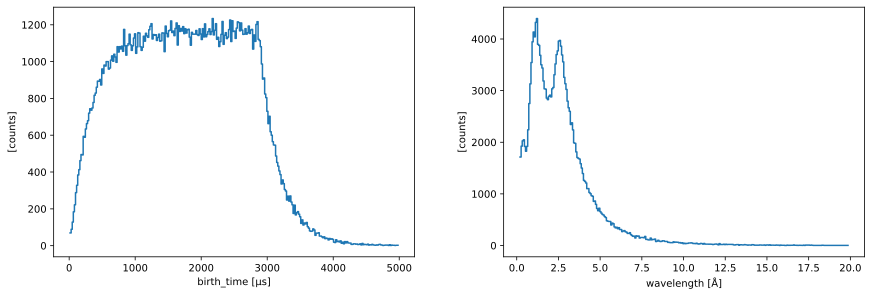

In [7]:
one_pulse = ess_beamline.source.data["pulse", 0]
one_pulse.hist(birth_time=300).plot() + one_pulse.hist(wavelength=300).plot()

Plot(ax=<Axes: xlabel='Time [μs]', ylabel='Distance [m]'>, fig=<Figure size 1200x480 with 2 Axes>)

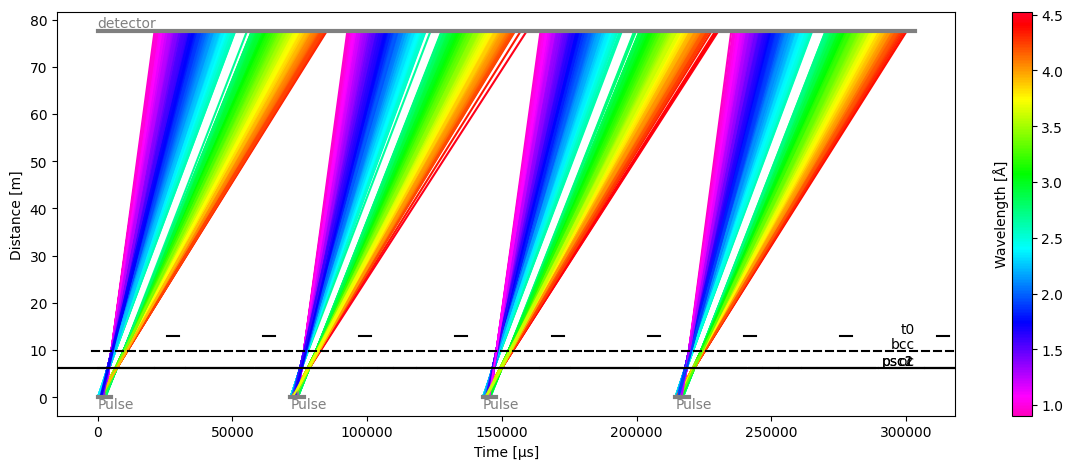

In [8]:
ess_beamline.model_result.plot()

From this fake beamline, we extract the raw neutron signal at our detector:

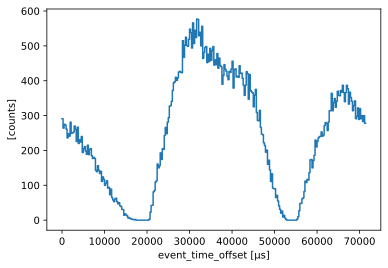

In [9]:
raw_data = ess_beamline.get_monitor("detector")[0]

# Visualize
raw_data.hist(event_time_offset=300).squeeze().plot()

The total number of neutrons in our sample data that make it through the to detector is:

In [10]:
raw_data.sum().value

np.float64(72878.0)

## Computing time-of-flight

Next, we use a workflow that provides an estimate of the real time-of-flight as a function of neutron time-of-arrival.

### Setting up the workflow

In [11]:
wf = GenericTofWorkflow(run_types=[SampleRun], monitor_types=[])

wf[RawDetector[SampleRun]] = raw_data
wf[DetectorLtotal[SampleRun]] = Ltotal
wf[NeXusDetectorName] = 'dream_detector'
wf[LookupTableRelativeErrorThreshold] = {'dream_detector': float("inf")}

wf.visualize(TofDetector[SampleRun])

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

By default, the workflow tries to load a `TofLookupTable` from a file.

In this notebook, instead of using such a pre-made file,
we will build our own lookup table from the chopper information and apply it to the workflow.

### Building the time-of-flight lookup table

We use the [Tof](https://scipp.github.io/tof/) package to propagate a pulse of neutrons through the chopper system to the detectors,
and predict the most likely neutron wavelength for a given time-of-arrival and distance from source.

From this,
we build a lookup table on which bilinear interpolation is used to compute a wavelength (and its corresponding time-of-flight)
for every neutron event.

In [12]:
lut_wf = TofLookupTableWorkflow()
lut_wf[DiskChoppers[AnyRun]] = disk_choppers
lut_wf[SourcePosition] = source_position
lut_wf[LtotalRange] = (
    sc.scalar(5.0, unit="m"),
    sc.scalar(80.0, unit="m"),
)
lut_wf.visualize(TofLookupTable)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Inspecting the lookup table

The workflow first runs a simulation using the chopper parameters above,
and the result is stored in `SimulationResults` (see graph above).

From these simulated neutrons, we create figures displaying the neutron wavelengths and time-of-flight,
as a function of arrival time at the detector.

This is the basis for creating our lookup table.

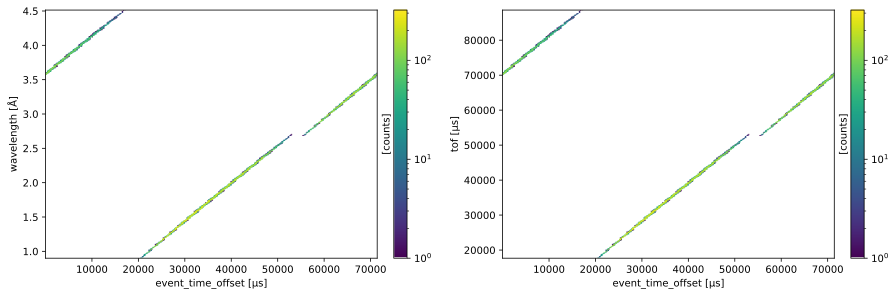

In [13]:
sim = lut_wf.compute(SimulationResults)


def to_event_time_offset(sim):
    # Compute event_time_offset at the detector
    eto = (
        sim.time_of_arrival + ((Ltotal - sim.distance) / sim.speed).to(unit="us")
    ) % sc.scalar(1e6 / 14.0, unit="us")
    # Compute time-of-flight at the detector
    tof = (Ltotal / sim.speed).to(unit="us")
    return sc.DataArray(
        data=sim.weight,
        coords={"wavelength": sim.wavelength, "event_time_offset": eto, "tof": tof},
    )


events = to_event_time_offset(sim.readings["t0"])
fig1 = events.hist(wavelength=300, event_time_offset=300).plot(norm="log")
fig2 = events.hist(tof=300, event_time_offset=300).plot(norm="log")
fig1 + fig2

The lookup table is then obtained by computing the weighted mean of the time-of-flight inside each time-of-arrival bin.

This is illustrated by the orange line in the figure below:

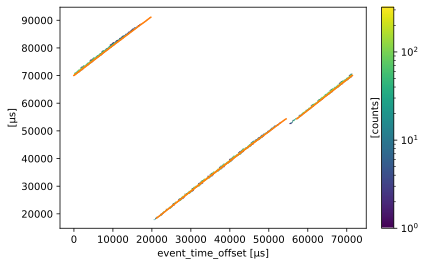

In [14]:
table = lut_wf.compute(TofLookupTable)

# Overlay mean on the figure above
table.array["distance", -1].plot(ax=fig2.ax, color="C1", ls="-", marker=None)

The full table covers a range of distances, and looks like

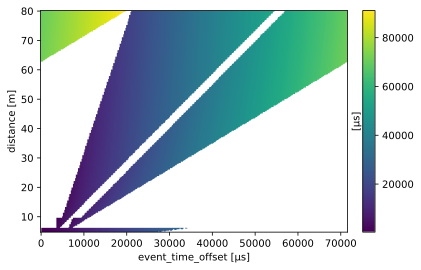

In [15]:
table.plot()

### Computing a time-of-flight coordinate

We will now update our workflow, and use it to obtain our event data with a time-of-flight coordinate:

In [16]:
# Set the computed lookup table onto the original workflow
wf[TofLookupTable] = table

# Compute time-of-flight of neutron events
tofs = wf.compute(TofDetector[SampleRun])
tofs

<scipp.DataArray>
Dimensions: Sizes[detector_number:1, ]
Coordinates:
* Ltotal                    float64              [m]  ()  77.675
Data:
                          DataArrayView        <no unit>  (detector_number)  binned data: dim='event', content=DataArray(
          dims=(event: 72878),
          data=float64[counts],
          coords={'id':int64, 'eto':float64[µs], 'event_time_zero':datetime64[µs],
                  'tof':float64[µs]})

Histogramming the data for a plot should show a profile with 6 bumps that correspond to the frames:

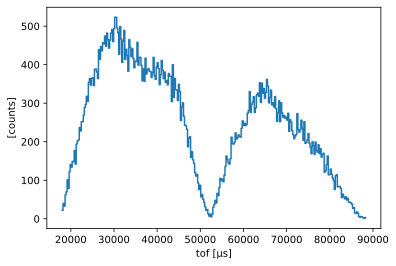

In [17]:
tofs.bins.concat().hist(tof=300).plot()

### Converting to wavelength

We can now convert our new time-of-flight coordinate to a neutron wavelength, using `tranform_coords`:

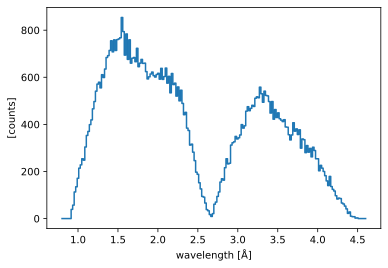

In [18]:
from scippneutron.conversion.graph.beamline import beamline
from scippneutron.conversion.graph.tof import elastic

# Perform coordinate transformation
graph = {**beamline(scatter=False), **elastic("tof")}
wav_wfm = tofs.transform_coords("wavelength", graph=graph)

# Define wavelength bin edges
wavs = sc.linspace("wavelength", 0.8, 4.6, 201, unit="angstrom")

histogrammed = wav_wfm.hist(wavelength=wavs).squeeze()
histogrammed.plot()

### Comparing to the ground truth

As a consistency check, because we actually know the wavelengths of the neutrons we created,
we can compare the true neutron wavelengths to those we computed above.

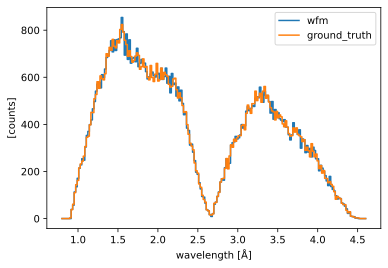

In [19]:
ground_truth = ess_beamline.model_result["detector"].data.flatten(to="event")
ground_truth = ground_truth[~ground_truth.masks["blocked_by_others"]]

pp.plot(
    {
        "wfm": histogrammed,
        "ground_truth": ground_truth.hist(wavelength=wavs),
    }
)

## Multiple detector pixels

It is also possible to compute the neutron time-of-flight for multiple detector pixels at once,
where every pixel has different frame bounds
(because every pixel is at a different distance from the source).

In our setup, we simply propagate the same neutrons to multiple detector pixels,
as if they were not absorbed by the first pixel they meet.

In [20]:
Ltotal = sc.array(dims=["detector_number"], values=[77.675, 76.0], unit="m")
monitors = {f"detector{i}": ltot for i, ltot in enumerate(Ltotal)}

ess_beamline = FakeBeamline(
    choppers=disk_choppers,
    source_position=source_position,
    monitors=monitors,
    run_length=sc.scalar(1 / 14, unit="s") * 4,
    events_per_pulse=200_000,
)

Our raw data has now a `detector_number` dimension of length 2.

We can plot the neutron `event_time_offset` for the two detector pixels and see that the offsets are shifted to the left for the pixel that is closest to the source.

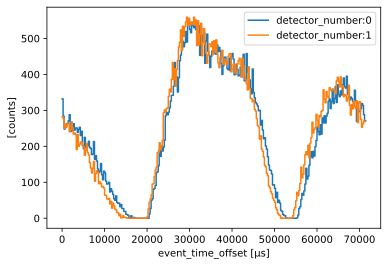

In [21]:
raw_data = sc.concat(
    [ess_beamline.get_monitor(key)[0].squeeze() for key in monitors.keys()],
    dim="detector_number",
)

# Visualize
pp.plot(sc.collapse(raw_data.hist(event_time_offset=300), keep="event_time_offset"))

Computing time-of-flight is done in the same way as above.
We need to remember to update our workflow:

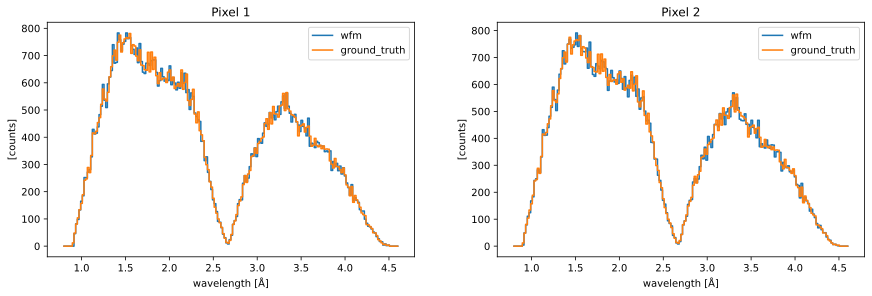

In [22]:
# Update workflow
wf[RawDetector[SampleRun]] = raw_data
wf[DetectorLtotal[SampleRun]] = Ltotal

# Compute tofs and wavelengths
tofs = wf.compute(TofDetector[SampleRun])
wav_wfm = tofs.transform_coords("wavelength", graph=graph)

# Compare in plot
ground_truth = []
for det in ess_beamline.monitors:
    data = ess_beamline.model_result[det.name].data.flatten(to="event")
    ground_truth.append(data[~data.masks["blocked_by_others"]])

figs = [
    pp.plot(
        {
            "wfm": wav_wfm["detector_number", i].bins.concat().hist(wavelength=wavs),
            "ground_truth": ground_truth[i].hist(wavelength=wavs),
        },
        title=f"Pixel {i+1}",
    )
    for i in range(len(Ltotal))
]

figs[0] + figs[1]

## Handling time overlap between subframes

In some (relatively rare) cases, where a chopper cascade is slightly ill-defined,
it is sometimes possible for some subframes to overlap in time with other subframes.

This is basically when neutrons passed through different pulse-shaping chopper openings,
but arrive at the same time at the detector.

In this case, it is actually not possible to accurately determine the wavelength of the neutrons.
ScippNeutron handles this by masking the overlapping regions and throwing away any neutrons that lie within it.

To simulate this, we modify slightly the phase and the cutouts of the band-control chopper:

Plot(ax=<Axes: xlabel='Time [μs]', ylabel='Distance [m]'>, fig=<Figure size 1200x480 with 2 Axes>)

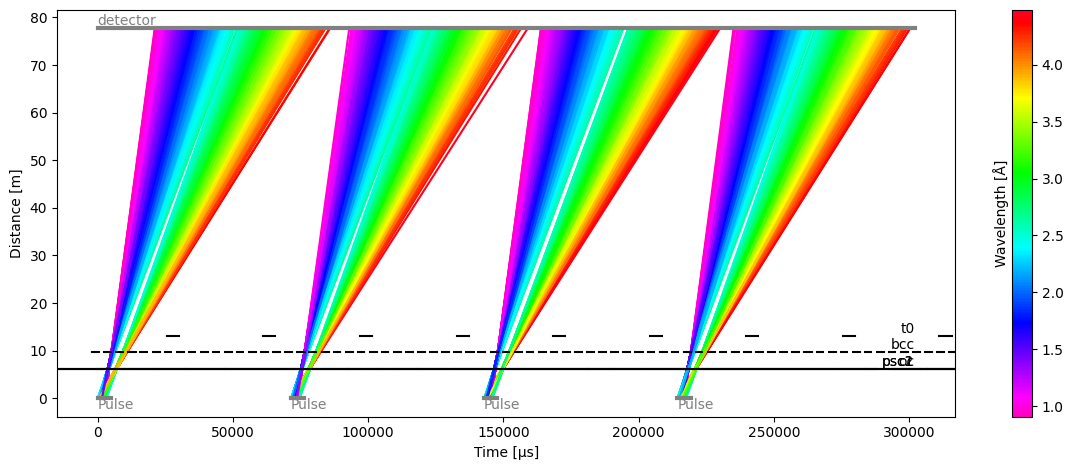

In [23]:
disk_choppers["bcc"] = DiskChopper(
    frequency=sc.scalar(112.0, unit="Hz"),
    beam_position=sc.scalar(0.0, unit="deg"),
    phase=sc.scalar(240 - 180, unit="deg"),
    axle_position=sc.vector(value=[0, 0, -66.77], unit="m"),
    slit_begin=sc.array(dims=["cutout"], values=[-36.875, 143.125], unit="deg"),
    slit_end=sc.array(dims=["cutout"], values=[46.875, 216.875], unit="deg"),
    slit_height=sc.scalar(10.0, unit="cm"),
    radius=sc.scalar(30.0, unit="cm"),
)

# Go back to a single detector pixel
Ltotal = sc.scalar(76.55 + 1.125, unit="m")

ess_beamline = FakeBeamline(
    choppers=disk_choppers,
    source_position=source_position,
    monitors={"detector": Ltotal},
    run_length=sc.scalar(1 / 14, unit="s") * 4,
    events_per_pulse=200_000,
)

ess_beamline.model_result.plot()

We can now see that there is no longer a gap between the two frames at the center of each pulse (green region).

Another way of looking at this is looking at the wavelength vs time-of-arrival plot,
which also shows overlap in time at the junction between the two frames:

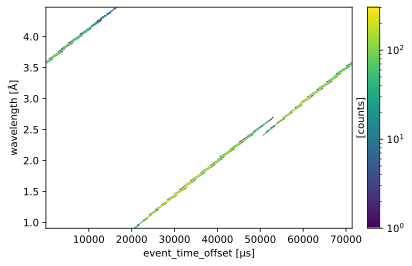

In [24]:
# Update workflow
lut_wf[DiskChoppers[AnyRun]] = disk_choppers

sim = lut_wf.compute(SimulationResults)

events = to_event_time_offset(sim.readings["t0"])
events.hist(wavelength=300, event_time_offset=300).plot(norm="log")

The data in the lookup table contains both the mean time-of-flight for each distance and time-of-arrival bin,
but also the variance inside each bin.

In the regions where there is no time overlap,
the variance is small (the regions are close to a thin line).
However, in the central region where overlap occurs,
we are computing a mean between two regions which have similar 'brightness'.

This leads to a large variance, and this is visible when plotting the relative standard deviations on a 2D figure
(we zoom in on the distances corresponding to the detector banks around 75m from the source).

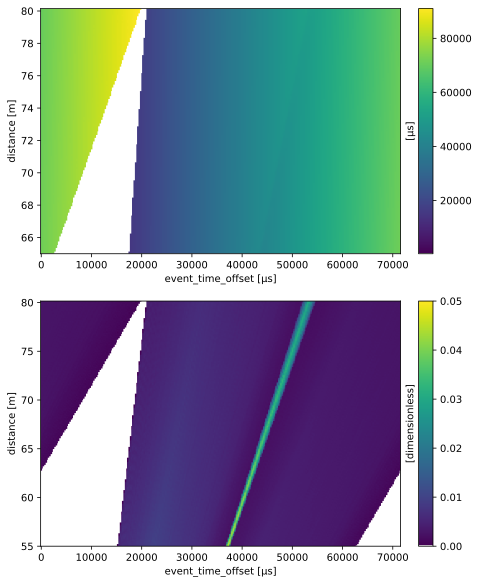

In [25]:
table = lut_wf.compute(TofLookupTable)
table.plot(ymin=65) / (sc.stddevs(table.array) / sc.values(table.array)).plot(norm="linear", ymin=55, vmax=0.05)

The workflow has a parameter which is used to mask out regions where the standard deviation is above a certain threshold.

It is difficult to automatically detector this threshold,
as it can vary a lot depending on how much signal is received by the detectors,
and how far the detectors are from the source.
It is thus more robust to simply have a user tunable parameter on the workflow.

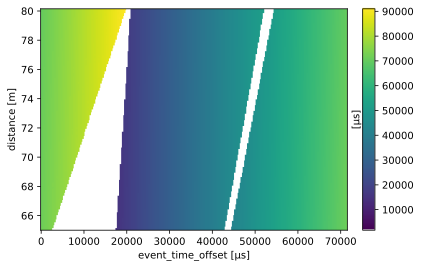

In [26]:
wf[TofLookupTable] = table

wf[LookupTableRelativeErrorThreshold] = {'dream_detector': 0.01}

masked_table = wf.compute(ErrorLimitedTofLookupTable[snx.NXdetector])
masked_table.plot(ymin=65)

We can now see that the central region is masked out.

The neutrons in that region will be discarded in the time-of-flight calculation
(in practice, they are given a NaN value as a time-of-flight).

This is visible when comparing to the true neutron wavelengths,
where we see that some counts were lost between the two frames.

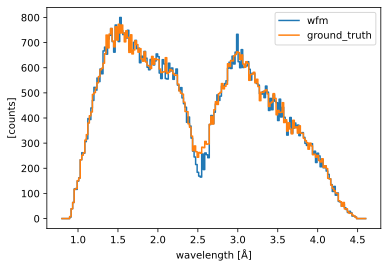

In [27]:
wf[RawDetector[SampleRun]] = ess_beamline.get_monitor("detector")[0]
wf[DetectorLtotal[SampleRun]] = Ltotal

# Compute time-of-flight
tofs = wf.compute(TofDetector[SampleRun])
# Compute wavelength
wav_wfm = tofs.transform_coords("wavelength", graph=graph)

# Compare to the true wavelengths
ground_truth = ess_beamline.model_result["detector"].data.flatten(to="event")
ground_truth = ground_truth[~ground_truth.masks["blocked_by_others"]]

pp.plot(
    {
        "wfm": wav_wfm.hist(wavelength=wavs).squeeze(),
        "ground_truth": ground_truth.hist(wavelength=wavs),
    }
)